In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [19]:

# Define constants
IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 7  # Updated for the new dataset

DATA_DIR = "/home/qod120/Documents/project/2nd_ai_web_project/ai_model/Cat Emotions.v1i.multiclass/train"
CSV_FILE = os.path.join(DATA_DIR, "_classes.csv")
PRETRAINED_MODEL_PATH = "/home/qod120/Documents/project/2nd_ai_web_project/ai_model/cat_emotion_mobilenet_model.h5"
FINE_TUNED_MODEL_PATH = "cat_emotion_mobilenet_finetuned_v1.h5"

def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the convolutional base

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model


In [20]:

def load_data(csv_file, data_dir, image_width, image_height):
    df = pd.read_csv(csv_file)
    
    class_columns = df.columns.drop('filename').tolist()
    
    df['filename'] = df['filename'].apply(lambda x: os.path.join(data_dir, x))
    
    return df, class_columns


In [21]:

def prepare_data(csv_file, data_dir, image_width, image_height, batch_size):
    df, class_columns = load_data(csv_file, data_dir, image_width, image_height)
    
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    validation_split_ratio = 0.2
    validation_samples = int(len(df) * validation_split_ratio)
    
    train_df = df.iloc[validation_samples:]
    validation_df = df.iloc[:validation_samples]
    
    num_classes = len(class_columns)
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col=class_columns,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        x_col='filename',
        y_col=class_columns,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False
    )
    return train_generator, validation_generator, class_columns, num_classes


In [22]:

def build_and_compile_model(input_shape, num_classes):
    # Create the MobileNetV2 base model, excluding the top (classification) layer
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Freeze the convolutional base
    base_model.trainable = False
        
    # Create a new model on top of the pre-trained base
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model


In [23]:

def train_and_save_model(model, train_generator, validation_generator, epochs, batch_size):
    history = model.fit(
        train_generator,
        steps_per_epoch=int(np.ceil(train_generator.samples / batch_size)),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(validation_generator.samples / batch_size))
    )
    model.save(FINE_TUNED_MODEL_PATH)
    print(f"Model trained and saved as {FINE_TUNED_MODEL_PATH}")
    return history


In [24]:

def evaluate_and_display_predictions(model_path, validation_generator, class_columns):
    loaded_model = tf.keras.models.load_model(model_path)

    validation_images, validation_labels = next(validation_generator)
    predictions = loaded_model.predict(validation_images)

    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(validation_images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(validation_images[i])
        true_label = class_columns[np.argmax(validation_labels[i])].replace('Unlabeled', 'No Emotion')
        predicted_label = class_columns[np.argmax(predictions[i])].replace('Unlabeled', 'No Emotion')
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()


Found 1657 validated image filenames.
Found 414 validated image filenames.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,917,447 (11.13 MB)

 Trainable params: 659,463 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step - accuracy: 0.5432 - loss: 1.2966 - val_accuracy: 0.6449 - val_loss: 0.9585
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.5854 - loss: 0.9679 - val_accuracy: 0.6667 - val_loss: 0.9115
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.6240 - loss: 0.9326 - val_accuracy: 0.6570 - val_loss: 0.9194
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.6180 - loss: 0.9141 - val_accuracy: 0.6329 - val_loss: 0.9384
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.6144 - loss: 0.8968 - val_accuracy: 0.6449 - val_loss: 0.9422
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 274ms/step - accuracy: 0.6150 - loss: 0.9020 - val_accuracy: 0.6667 - val_loss: 0.9257
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - accuracy: 0.6397 - loss: 0.8817 - val_accuracy: 0.6908 - val_loss: 0.9508
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.6210 - loss: 0.8869 - val_accu

Model trained and saved as cat_emotion_mobilenet_finetuned_v1.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


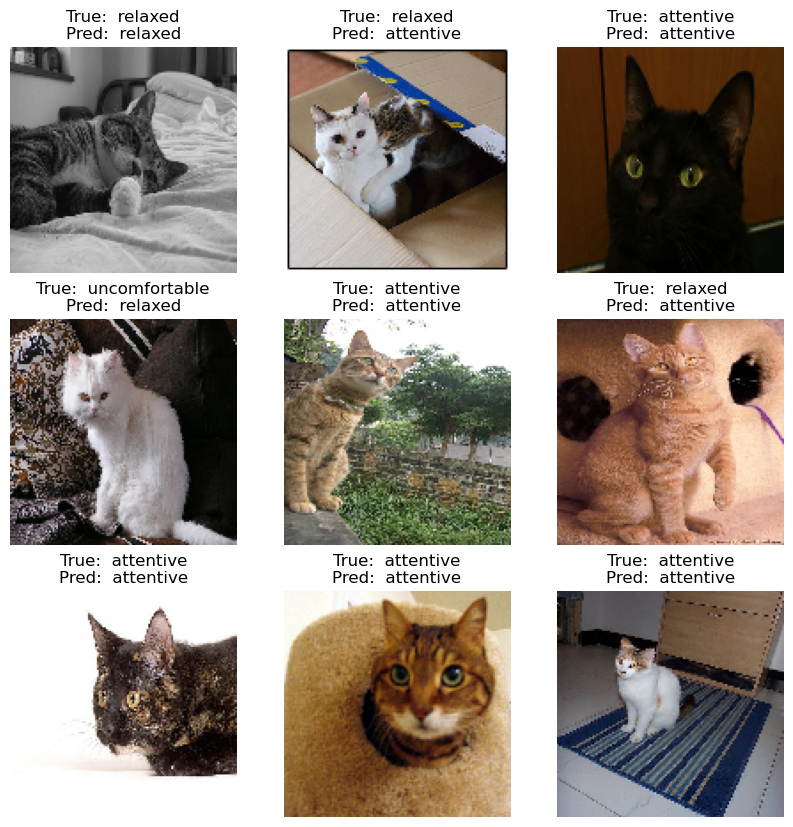

In [25]:

def train_model():
    train_generator, validation_generator, class_columns, num_classes = prepare_data(
        CSV_FILE, DATA_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, BATCH_SIZE
    )
    
    model = build_and_compile_model((IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes)
    
    train_and_save_model(model, train_generator, validation_generator, EPOCHS, BATCH_SIZE)
    
    evaluate_and_display_predictions(FINE_TUNED_MODEL_PATH, validation_generator, class_columns)

if __name__ == "__main__":
    train_model()
